# Coffea-Casa Benchmark Example 6

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots the pT of the trijet system in each event with mass closest to 172.5, as well as the maximum b-tag among the three plotted jets.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet [GeV]", 50, 15, 200)
        b_tag_axis = hist.Bin("b_tag", "b-tagging discriminant", 50, 0, 1)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'b_tag': hist.Hist("Counts", dataset_axis, b_tag_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        jets = events.Jet
        
        # Closest calculates the distance from 172.5 of a group of masses, finds the minimum distance, then returns a Boolean array of the original input array shape with True where the minimum-distance mass is located.
        def closest(masses):
            delta = abs(172.5 - masses)
            closest_masses = ak.min(delta, axis=1)
            is_closest = (delta == closest_masses)
            return is_closest
        
        # We're going to be generating combinations of three jets - that's a lot, and cutting pt off at 30 reduces jets by half.
        cut_jets = jets[jets.pt > 30]
        
        # Get all combinations of three jets.
        trijets = ak.combinations(cut_jets, 3, fields=['i0', 'i1', 'i2'])
        # Get combined masses of those combinations, by adding all p4's and then taking .mass.
        trijet_masses = (trijets['i0'] + trijets['i1'] + trijets['i2']).mass
        # Get the masses closest to specified value (see function above)
        is_closest = closest(trijet_masses)
        closest_trijets = trijets[is_closest]
        # Get pt of the closest trijets.
        closest_pt = (closest_trijets['i0'] + closest_trijets['i1'] + closest_trijets['i2']).pt
        # Get btag of the closest trijets. np.maximum(x,y) compares two arrays and gets element-wise maximums. We make two comparisons - once between the first and second jet, then between the first comparison and the third jet.
        closest_btag = np.maximum(np.maximum(closest_trijets['i0'].btag, closest_trijets['i1'].btag), closest_trijets['i2'].btag)
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(closest_pt))
        output['b_tag'].fill(dataset=dataset, b_tag=ak.flatten(closest_btag))
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 5549754105,
 'columns': {'Jet_btag', 'Jet_eta', 'Jet_mass', 'Jet_phi', 'Jet_pt', 'nJet'},
 'entries': 53446198,
 'processtime': 1691.7462303638458,
 'chunks': 534}

<AxesSubplot:xlabel='Jet [GeV]', ylabel='Counts'>

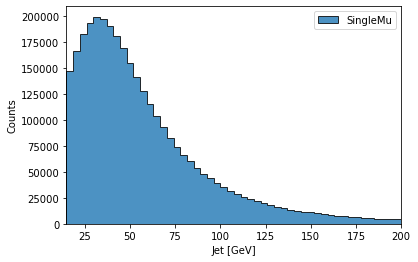

In [5]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

<AxesSubplot:xlabel='b-tagging discriminant', ylabel='Counts'>

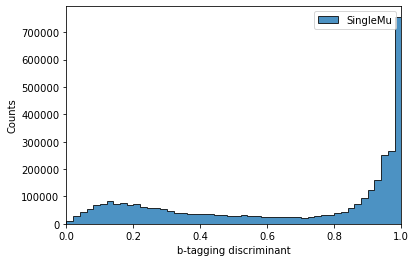

In [6]:
hist.plot1d(output['b_tag'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})